# $\textit{Análisis de respuestas impulsivas}$
$\textit{Filtro lineal óptimo}$

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal as sp
import helper as hp
import importlib
importlib.reload(hp)

<module 'helper' from 'c:\\Users\\Gonzalo\\Documents\\Informatica\\EclipseWorkspacePython\\PASA_TP2\\helper.py'>

In [2]:
%matplotlib widget

# $\textit{1)}$

In [3]:
fs = 48000
t = np.linspace(0, 10, 10*fs, endpoint=False)
f0 = 20
f1 = 20000
T = 10
k = (f1/f0)**(1/T)

chirpLinearSignal = sp.chirp(t, f0=f0, t1=10, f1=f1, method='linear')
chirpExpSignal = np.sin(2 * np.pi * f0 * (k**t-1)/np.log(k))
gaussSignal = np.random.normal(0, 1, size=fs*10)
squareSignal = sp.square(2 * np.pi * 100 * t)

Para la selección de la señal de música, realizamos una búsqueda entre distintos géneros musicales y observamos los espectros de potencia de algunas canciones. Buscamos aquella canción que contenga dentro de los 10 segundos a utilizar, la mayor cantidad de frecuencias posibles. Finalmente, elegimos la canción "Fly me to the moon" de Frank Sinatra por su contenido en frecuencia.

Nuevamente, para la señal de voz, se utilizó el mismo criterio que para la selección de la señal de música.

In [4]:
origfs, origSignal, origpath = hp.getOriginalSignals()

In [5]:
recfs, recSignal, recpath = hp.getRecordedSignals()

c:\Users\Gonzalo\Documents\Informatica\EclipseWorkspacePython\PASA_TP2\helper.py:36: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs1, recmusicSignal = io.wavfile.read(path[0])
c:\Users\Gonzalo\Documents\Informatica\EclipseWorkspacePython\PASA_TP2\helper.py:37: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs2, recVoiceSignal = io.wavfile.read(path[1])
c:\Users\Gonzalo\Documents\Informatica\EclipseWorkspacePython\PASA_TP2\helper.py:38: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs3, recchirpLinearSignal = io.wavfile.read(path[2])
c:\Users\Gonzalo\Documents\Informatica\EclipseWorkspacePython\PASA_TP2\helper.py:39: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs4, recchirpExpSignal = io.wavfile.read(path[3])
c:\Users\Gonzalo\Documents\Informatica\EclipseWorkspacePython\PASA_TP2\helper.py:40: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs5, recgaussSignal = io.wavfile.read(path[4])
c:\Users\Go

# $\textit{2)}$

Observando los gráficos de las PSDs, intuimos que la señal que mejor va funcionar para obtener h(n) es el barrido lineal porque excita al sistema (en este caso en el living de una casa) con un espectro de potencia más constante en escala logarítmica que los demás. También se puede apreciar que tanto el barrido lineal y el exponencial son aquellos que menos dispersion tienen.

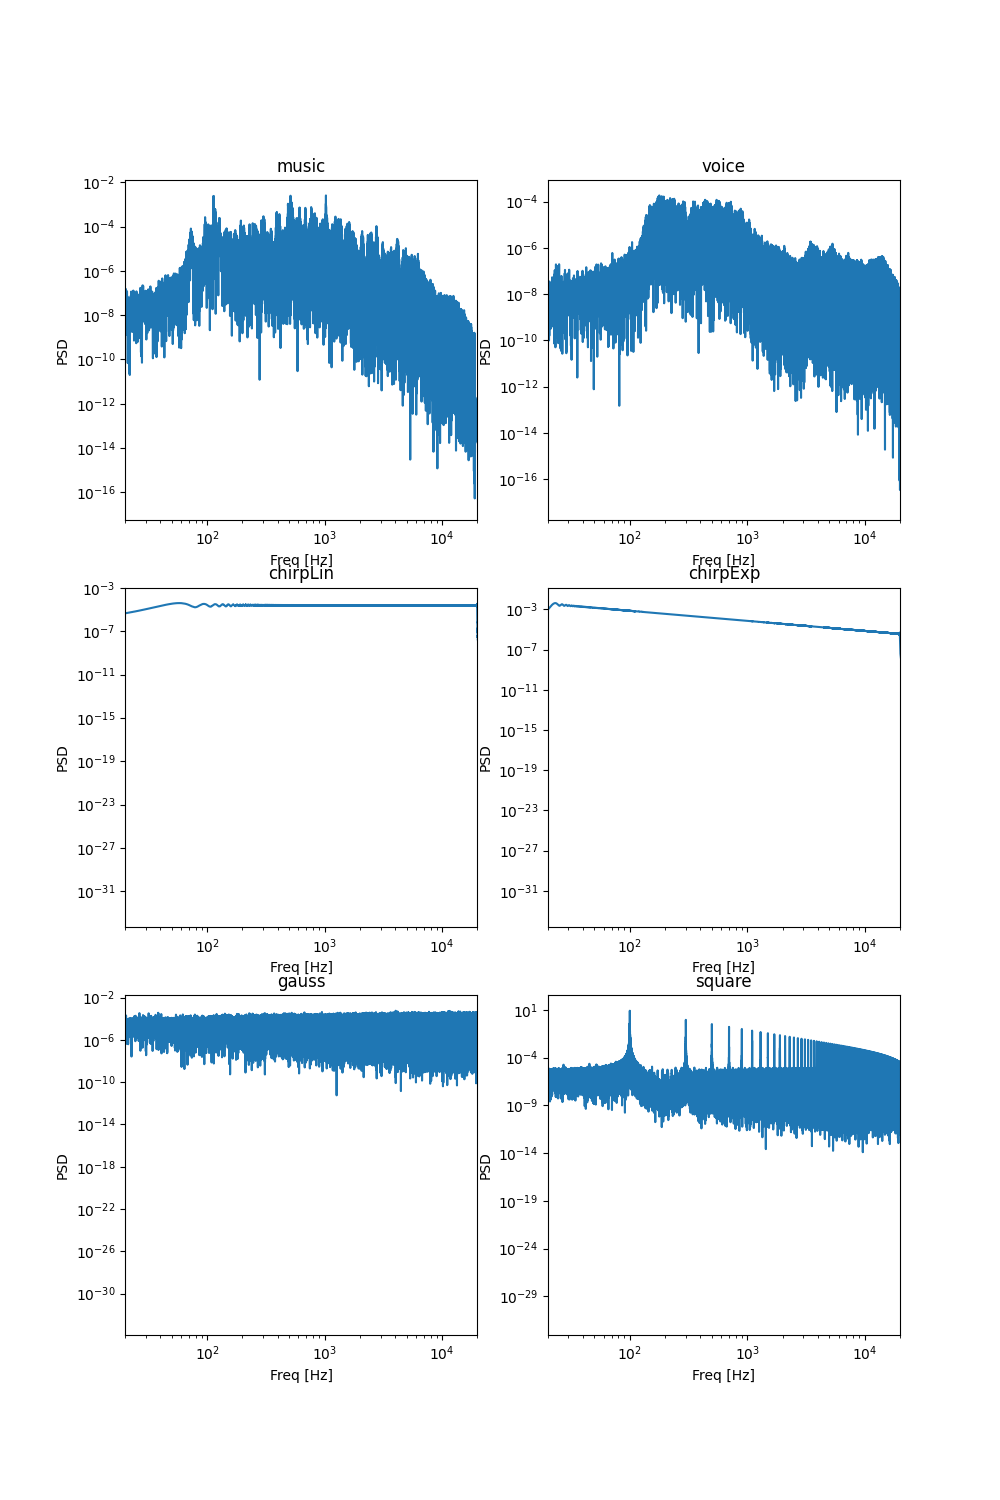

In [20]:
plt.figure(figsize=(10, 15))

for i, (name, s) in enumerate(zip(origSignal.keys(), origSignal.values())):
    f, Pxx_den = sp.periodogram(s, fs=fs, window='boxcar', nfft=hp.getNextPowerOfTwo(len(s)*5))
    plt.subplot(3, 2, i+1)
    plt.title(f"{name}")
    plt.xlabel('Freq [Hz]')
    plt.ylabel('PSD')
    plt.xlim((f0, f1))
    plt.loglog(f, Pxx_den)

$\textit{Modelado de sistema}$

$$ w_o = R^{-1}*p $$

Dado que las señales son reales:

$$ R = \begin{bmatrix}
Rxx(0) & Rxx (1) & ... & Rxx(M-1) \\
Rxx(1) & Rxx (0) & ... & Rxx(M-2) \\
... & & & \\

\end{bmatrix}
$$
$$ p = \begin{bmatrix}
Rxy(1) & Rxy (2) & ... & Rxy(M) \\

\end{bmatrix}
$$

# $\textit{3)}$ 

Para determinar el valor del orden óptimo M, utilizamos el criterio de que la variación porcentual entre el valor n+1 respecto al valor n sea menor al 0.05%. Utilizando este criterio, obtuvimos que el orden óptimo M = 9242.

¿Cómo podemos reducir el cálculo necesario?

Para reducir el cálculo necesario, se hizo uso de la función de scipy "solve_toeplitz" que implementa el algoritmo de Levinson–Durbin, el cúal tiene una complejidad de 
O(n^2).


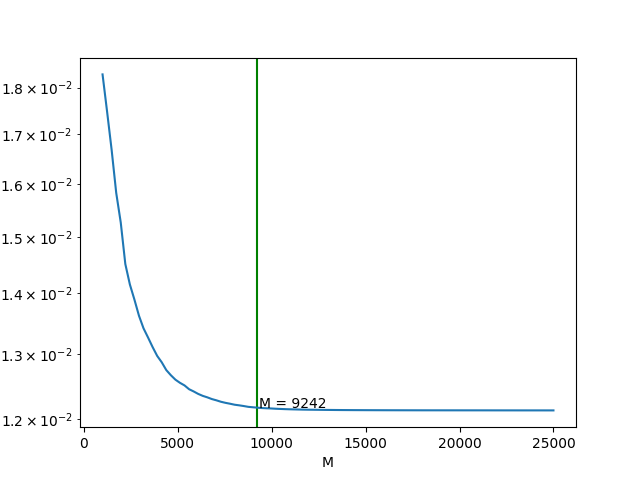

In [70]:
Ms = np.linspace(1000, 25000, 100, dtype=int)
jos = np.zeros(len(Ms))
found = False
last = 0

plt.figure()
for i, M in enumerate(Ms):
    wo, jo, nmse = hp.get_optimal_params(origSignal['chirpLin'], recSignal['chirpLin'], M)
    jos[i] = jo
    if i != 0 and last/jo-1 < 0.0005 and not found:
        plt.axvline(x=Ms[i], c='green')
        plt.text(x=Ms[i]+100, y=jo, s=f'M = {Ms[i]}')
        found = True
    last = jo

plt.xlabel('M')
plt.ylabel('MSE mínimo')
plt.semilogy(Ms, jos)

# $\textit{4)}$



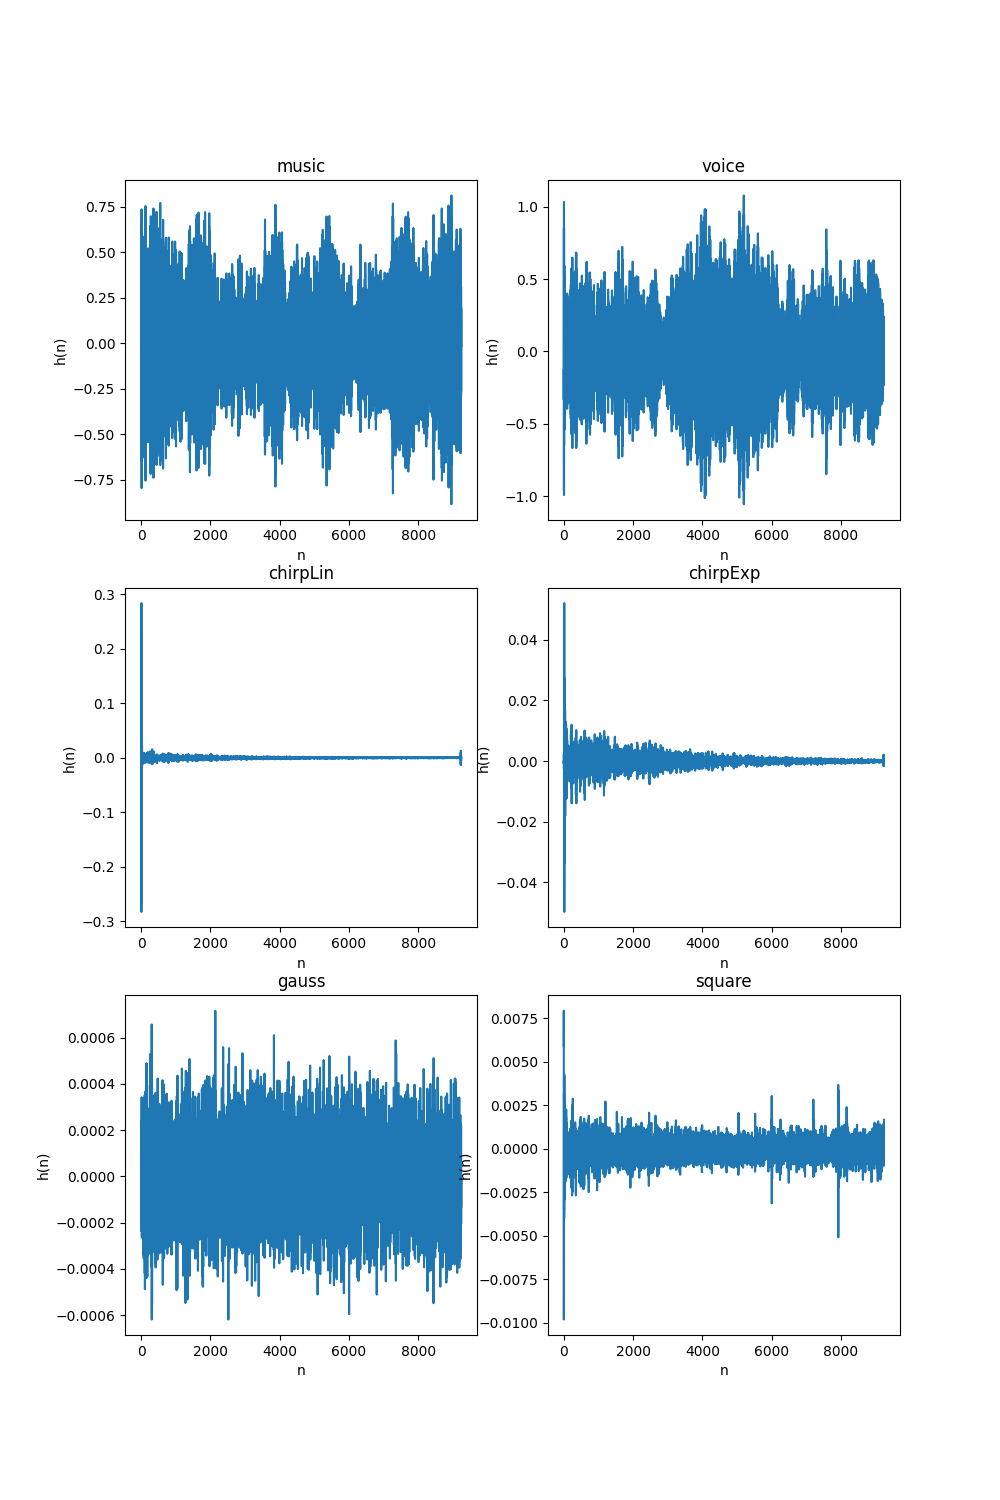

In [71]:
M = 9242 #Ordenes optimo encontrado
h_n = []
nmses = []

plt.figure(figsize=(10, 15))
for i, (name, os, rs) in enumerate(zip(origSignal.keys(), origSignal.values(), recSignal.values())):
    h, jo, nmse = hp.get_optimal_params(os, rs, M)
    plt.subplot(3, 2, i+1)
    plt.title(f"{name}")
    plt.xlabel('n')
    plt.ylabel('h(n)')
    plt.plot(h)
    h_n.append(h)
    nmses.append(nmse)
plt.show()

Obtenemos la respuesta en frecuencia de cada estimacion de h(n)

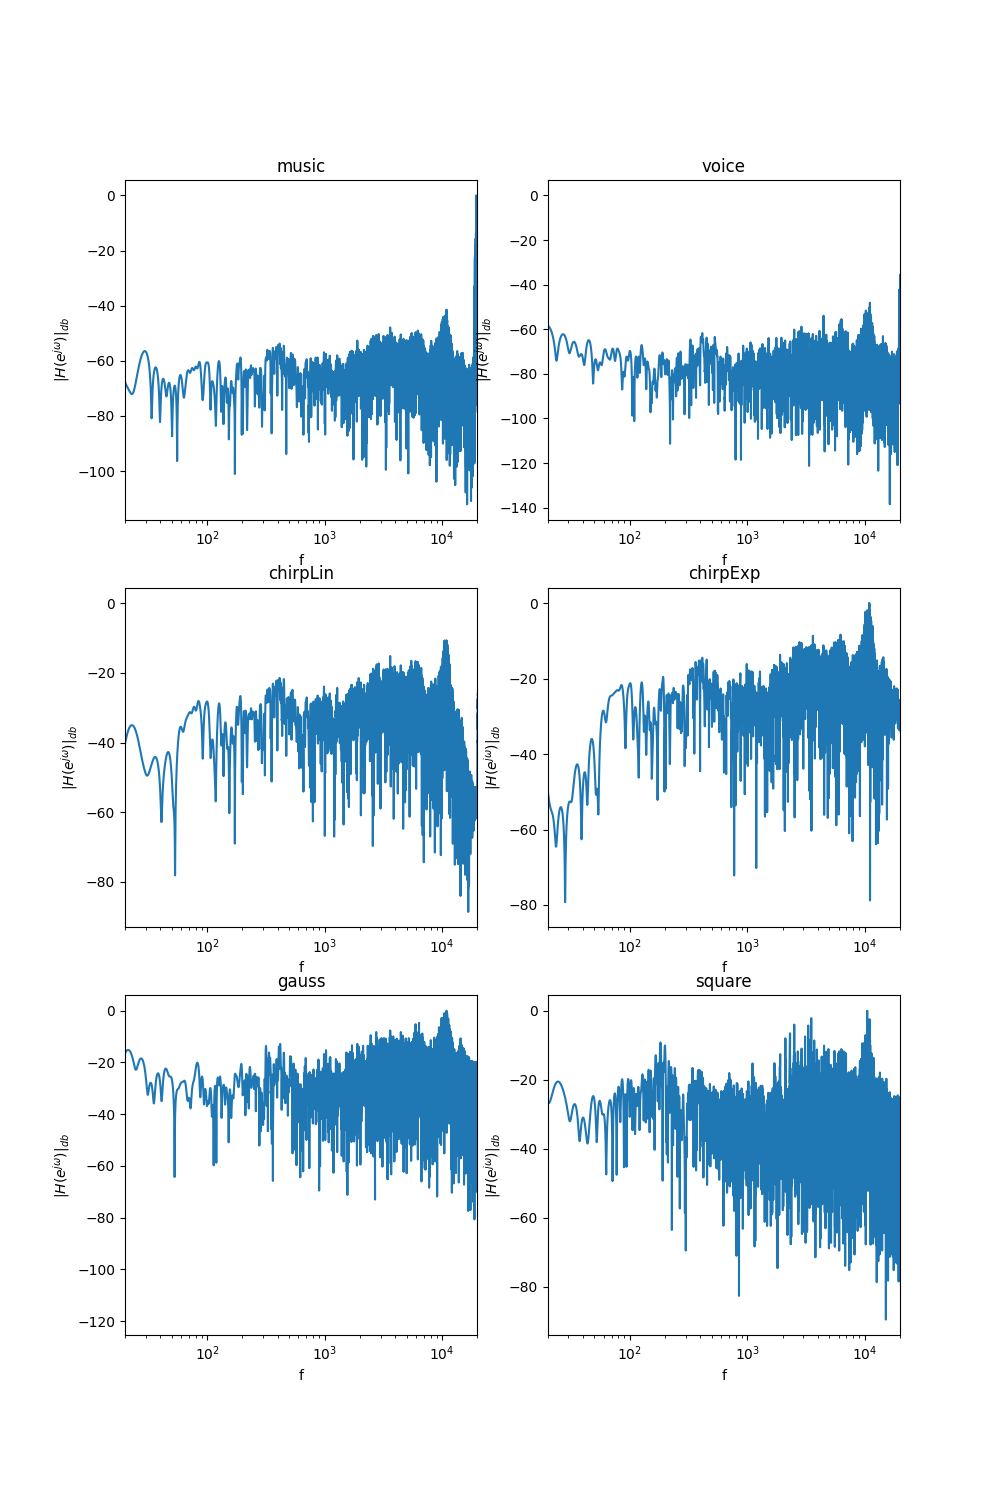

In [72]:
plt.figure(figsize=(10, 15))
for i, (name, h) in enumerate(zip(recSignal.keys(), h_n)):
    paddingLen = hp.getNextPowerOfTwo(len(h)*20)
    H = np.fft.rfft(h, paddingLen)
    f = np.fft.rfftfreq(paddingLen, 1/fs)

    plt.subplot(3, 2, i+1)
    plt.title(f"{name}")
    plt.xlabel('f')
    plt.ylabel('$|H(e^{j\omega})|_{db}$')
    plt.xlim([f0,f1])
    #plt.plot(f, 10*np.log10(np.abs(H)/abs(H).max()))
    plt.semilogx(f, 20*np.log10(np.abs(H)/abs(H).max()))
plt.show()

Calculamos los MSE normalizados

Esto no puede ser negativo mepa

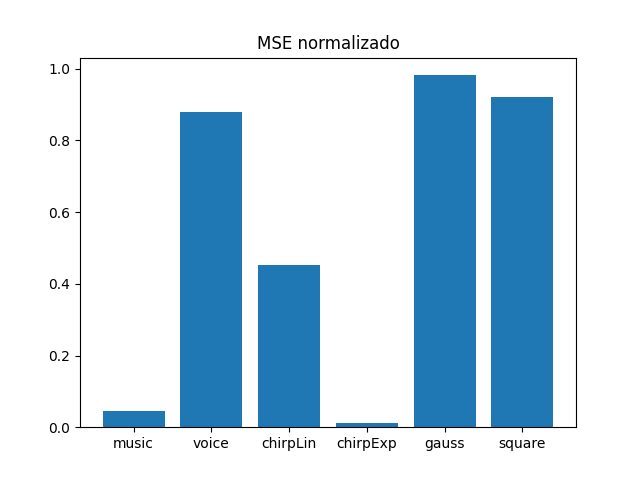

In [73]:
plt.figure()
plt.title("MSE normalizado")
plt.bar(recSignal.keys(), nmses)
plt.show()

Resultado

In [80]:
result = sp.convolve(h_n[0], recSignal['voice'], mode='full') / sum(recSignal['voice'])

In [82]:
hp.play(recSignal["voice"], recfs["voice"])

In [83]:
hp.play(result, fs)